### Notebook: POS (Part of Speech) approach

Use POS to keep only specific verb-noun, adj-noun,... relationships focusing on "inflation" as noun.

In [28]:
#!pip install ecbdata

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns
from tqdm import tqdm
from ecbdata import ecbdata
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer 
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors

import nltk
nltk.download('averaged_perceptron_tagger')

import spacy
sp = spacy.load('en_core_web_sm')

tqdm.pandas()

porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

#ECB Color
color = (17/255, 49/255, 147/255)

C:\Users\School\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\School\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**PoS: (Part of Speech)**

From the paper: Political metaphors in U.S. governor speeches

We will focus on the following word pairs: subject-verb, verb-object, adjective-noun and score them by their metaphoricity. 

**Choice between Stemming or Lemmatization:**

Stemming: Stemming is generally faster and simpler than lemmatization, but it may not always produce a valid word since it applies simple rules to chop off suffixes. In your case, stemming could potentially match "beat" with "beating" but may produce incorrect results in some cases.

Lemmatization: Lemmatization, on the other hand, maps words to their base or dictionary form, which is more linguistically accurate. It typically requires more computational resources compared to stemming but can provide more accurate results

Select modulation for this notebook:

In [2]:
# mod = 0 means just lowercase, mod = 1 means stemming, mod = 2 means lemmatizing
mod = 0

In [3]:
# Target words:
words_to_match = ["inflation","deflation","inflationary","desinflationary","hyperinflation","disinflation"]

In [4]:
# Functions:
def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos 
def tokenize(text, modulation):
    sentences = re.split(r'(?<=[.!?])\s+', text)  # Split text into sentences while preserving periods

    processed_sentences = []

    for sentence in sentences:
        if modulation < 2:
            # Tokenize and preprocess each sentence
            tokens = re.findall(r'\w+', sentence.lower())
            stems = []
            for token in tokens:
                lowers = abbr_or_lower(token)
                if lowers not in stop_words and re.search('[a-zA-Z]', lowers):
                    if modulation == 0:
                        stems.append(lowers)
                    elif modulation == 1:
                        stems.append(porter.stem(lowers))
            processed_sentence = " ".join(stems)
        else:
            doc = sp(sentence)
            lemmatized_tokens = []
            for token in doc:
                if token.text.strip():
                    lemmatized_tokens.append(token.lemma_)
            processed_sentence = " ".join(lemmatized_tokens)

        processed_sentences.append(processed_sentence)

    # Reconstruct the text with preserved sentence boundaries
    processed_text = " ".join(processed_sentences)

    return processed_text

def tokenize_word_list(word_list, modulation):
    processed_words = []

    for word in word_list:
        processed_word = word.lower()
        if modulation < 2:
            if modulation == 0:
                processed_words.append(processed_word)
            elif modulation == 1:
                processed_words.append(porter.stem(processed_word))
        else:
            # Apply lemmatization using spaCy
            doc = sp(word)
            lemmatized_text=[]
            for w_ in doc:
                lemmatized_text.append(w_.lemma_)
            processed_words.extend([abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)])

    return " ".join(processed_words)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_end_answer(text):
    text = text.replace(r'[end_answer]', '')
    return text

def remove_special_characters_keep_point(text):
    # Define the regex pattern to match special characters except "."
    pattern = r"[^\w\s\.\']"
    # Replace special characters with an empty string
    text = re.sub(pattern, '', text)
    # Replace consecutive dots with just one dot
    text = re.sub(r'\.{2,}', '.', text)
    return text

def remove_unnecessary_spaces(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def remove_starting_month(text):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    pattern = r'^(' + '|'.join(months) + r')\s'
    text = re.sub(pattern, '', text)
    return text

def vectorize(tokens, vocab):
    vector=[]
    for w in vocab:
        vector.append(tokens.count(w))
    return vector

def text_length_distribution(df):
    df['text_length'] = df['Answers'].apply(len)
    plt.figure(dpi=300)
    # Plot histogram with a label for the legend
    df['text_length'].hist(bins=30, color=color, label='Text Length')
    # Add title and labels
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

def pos_tagging(text):
    # Create a TextBlob object
    blob = TextBlob(text)
    # Return part of speech tags
    return blob.tags

def extract_relationships(text, words_to_match, lemmatize=False):
    """
    Input - Text
    Output - List of subject-verb, verb-object, adjective-noun relationships extracted from the text
    Caution: Only relationships containing words from the words_to_match list are extracted
    """
    relationships = []
    text = text.lower()
    doc = sp(text)

    # Iterate over each sentence in the text
    for sentence in doc.sents:
        sentence_relationships = []

        # Iterate over each token in the sentence
        for token in sentence:
            # Extract subject-verb relationships (nsubj = nominal subject, csubj = clausal subject)
            if token.dep_ in ['nsubj', 'csubj'] and token.head.pos_ == 'VERB':
                if any(word in [token.text, token.head.text] for word in words_to_match):
                    if lemmatize == False:
                        relationship = (token.text, token.head.text)
                        sentence_relationships.append(relationship)
                    else:
                        relationship = (token.lemma_, token.head.lemma_)
                        sentence_relationships.append(relationship)

            # Extract verb-object relationships (dobj = direct object)
            elif token.dep_ == 'dobj' and token.head.pos_ == 'VERB':
                if any(word in [token.text, token.head.text] for word in words_to_match):
                    if lemmatize == False:
                        relationship = (token.text, token.head.text)
                        sentence_relationships.append(relationship)
                    else:
                        relationship = (token.lemma_, token.head.lemma_)
                        sentence_relationships.append(relationship)

            # Extract adjective-noun relationships (amod = adjectival modifier)
            elif token.dep_ == 'amod' and token.head.pos_ == 'NOUN':
                if any(word in [token.text, token.head.text] for word in words_to_match):
                    if lemmatize == False:
                        relationship = (token.text, token.head.text)
                        sentence_relationships.append(relationship)
                    else:
                        relationship = (token.lemma_, token.head.lemma_)
                        sentence_relationships.append(relationship)

        relationships.extend(sentence_relationships)

    return relationships

def find_duplicates(words):
    duplicates = []
    seen = set()

    for word in words:
        # Check if the word has been seen before
        if word in seen:
            duplicates.append(word)
        else:
            seen.add(word)

    return duplicates

def remove_duplicates(sentence):
    words = sentence.split()
    # Convert the list of words into a set to remove duplicates
    unique_words = set(words)
    print(f'Unique words: {len(unique_words)}')
    # Join the unique words back into a string
    result = ' '.join(unique_words)
    return result

def find_metaphors_in_relationships(relationships, as_words):
    metaphors = []

    for relationship in relationships:
        # Check if any word in the tuple is in the as_words list
        if any(word in as_words for word in relationship):
            metaphors.append(relationship)

    return metaphors

In [6]:
# Import dataset containing the interveiw data
df = pd.read_csv('Final_Working_Data.csv')

# Convert 'date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Unnamed: 0,Date,Media,Member,Link,Information,Questions,Answers,Metaphors,Metaphors Sentence,YoB,Gender,Country,Period on the Board,list_regex,list_regex_reduced,list_regex_len,list_regex_reduced_len,text_length
0,0,2005-12-23,Interview with Der Spiegel,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"SPIEGEL: Monsieur Trichet, any concrete uttera...",The publication of the translation was authori...,NaN,NaN,1942,M,France,2003 - 2011,['we will in the future take the decision that...,['we will in the future take the decision that...,3,3,9371
1,1,2005-12-19,Interview with Hospodářské Noviny,Otmar Issing,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,The new EU member states want to adopt the eur...,These questions are all closely related to eac...,NaN,NaN,1936,M,Germany,1998 - 2006,['we be not confront with deflation but with i...,['we be not confront with deflation but with i...,1,1,3209
2,2,2005-12-19,Interview with Financial Times and Financial T...,Lucas Papademos,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"Mr Papademos, you have responsibility as ECB V...",A comparison of the risks involved when short-...,NaN,NaN,1947,M,Greece,2002 - 2010,['if longterm interest rate remain at a low le...,['if longterm interest rate remain at a low le...,11,10,16231
3,3,2005-12-15,Interview with Paris Match,Jean-Claude Trichet,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,Paris Match. After two uneventful years at the...,The publication of the translation was authori...,NaN,NaN,1942,M,France,2003 - 2011,['you be exaggerate the increase in the cost o...,['you be exaggerate the increase in the cost o...,5,4,8186
4,4,2005-12-09,Interview in Il Giornale,Lorenzo Bini Smaghi,https://www.ecb.europa.eu/press/inter/date/200...,Information not found,"However, Europe’s politicians, with few except...","By Angelo Allegri, our correspondent in Frankf...",NaN,NaN,1956,M,Italy,2005 - 2011,['the rise have help to keep inflation expecta...,['the rise have help to keep inflation expecta...,7,7,6765


In [7]:
print("Shape of the dataset before dropping missing values: ", df.shape)
df.isna().sum()

Shape of the dataset before dropping missing values:  (519, 19)


Unnamed: 0                  0
Date                        0
Media                       0
Member                      0
Link                        0
Information                 0
Questions                  51
Answers                    10
Metaphors                 451
Metaphors Sentence        451
YoB                         0
Gender                      0
Country                     0
Period on the Board         0
list_regex                  0
list_regex_reduced          0
list_regex_len              0
list_regex_reduced_len      0
text_length                 0
dtype: int64

In [8]:
print("Shape of the dataset after dropping missing values: ", df.shape)
df.nunique()

Shape of the dataset after dropping missing values:  (519, 19)


Unnamed: 0                519
Date                      489
Media                     259
Member                     19
Link                      519
Information               361
Questions                 465
Answers                   509
Metaphors                  59
Metaphors Sentence         59
YoB                        15
Gender                      2
Country                    10
Period on the Board        14
list_regex                407
list_regex_reduced        407
list_regex_len             38
list_regex_reduced_len     38
text_length               504
dtype: int64

In [9]:
#types of data
df.dtypes

Unnamed: 0                         int64
Date                      datetime64[ns]
Media                             object
Member                            object
Link                              object
Information                       object
Questions                         object
Answers                           object
Metaphors                         object
Metaphors Sentence                object
YoB                                int64
Gender                            object
Country                           object
Period on the Board               object
list_regex                        object
list_regex_reduced                object
list_regex_len                     int64
list_regex_reduced_len             int64
text_length                        int64
dtype: object

In [10]:
start = df["Date"].min()
start = start.strftime('%Y-%m')
df2 = ecbdata.get_series('ICP.M.U2.N.000000.4.ANR', 
                        start=start)
df2["TIME_PERIOD"] = pd.to_datetime(df2["TIME_PERIOD"])
print("Start date is: ",start)

Start date is:  2005-01


In [11]:
"""text_length_distribution(df)
# average text length
print("The mean length is: ",df['text_length'].mean())
"""

'text_length_distribution(df)\n# average text length\nprint("The mean length is: ",df[\'text_length\'].mean())\n'

In [12]:
# List of words to match: (taken from paper: Inflation Metaphor in Contemporary American English)
#as_fire = ['ignite', 'fuel', 'spark', 'dampen', 'stoke', 'kindle', 'choke', 'stifle', 'fan', 'flare-up', 'douse', 'snuff']
#as_liquids = ['erode', 'surge', 'subside', 'simmers', 'emergence', 'ebb', 'dilute', 'spurt', 'recede', 'buoy']
#as_plant = ['hedge','nip']
#as_animal = ['soar', 'runaway', 'rampant', 'curb', 'tame', 'rein', 'creep', 'whip', 'gallop', 'halt', 'roar', 'hover', 'curtail', 'spawn', 'gnaw', 'hibernation','Growl','Roar','Pounce','Stalk','Attack','Bite','Claw','Snarl','Charge','Hunt','Intimidate','Defend','Rend','Tear','Dominated','Fangs','Claws','Aggression','Predation','Territoriality','Hackles','Mane','Prowess','Strength','Ferocity','Dominance','Menace','Threat','piercing','glaring','Talons','Paws','Beak','Scales','Horns','Tusks','Quills','Tail','Jaws','Muzzle','Fierce','Intimidating','Savage','Vicious','Menacing','Aggressive','Predatory','Dominant','Territorial','Formidable','Ruthless','Daunting','Wild','Untamed','Ferocious','Hissing','bare','prey','teeth','savage','feral','voracious','primal','untamed','predatory','beastly','wild','barbarous','fierce','wolf','leopard','snake','shark','eagle','ruffling','feathers','poking','bear','bull','lion','flash','sharp','gnaw','predatory','spur','hibernate','hibernation','hibernating','span']
#as_disease = ['plague', 'worsen', 'benign', 'virulent', 'debilitate', 'bout', 'chronically']
#as_warfare = ['threat', 'subdue', 'target', 'beat', 'preempt', 'vigilant', 'ravage', 'undermine', 'forestall', 'counteract', 'eliminate', 'ferocious', 'ruinous', 'clobber', 'buster', 'eradicate', 'besieged', 'thwart', 'bash', 'beset']
#as_sports = ['pace', 'outstrip', 'lag', 'surpass', 'quicken', 'outrun', 'bout', 'best', 'tug-of-war', 'zip', 'overtake']
#as_machine = ['accelerate', 'faster', 'control', 'slow', 'trigger', 'skyrocket', 'rapid', 'heat', 'escalate', 'decelerate', 'ratchet', 'unchecked', 'readjusted', 'chug', 'damper', 'zoom']
#as_orientation = ['low', 'rise', 'high', 'increase', 'reduce', 'decline', 'fall', 'exceed', 'spiral', 'hyper', 'upward', 'uptick', 'downward', 'boost', 'peak', 'diminish', 'upturn', 'hike', 'plummet', 'upswing']


# List of words to match: (Mix of words from the paper and other sources (e.g. ChatGPT))
as_plant = ['hedge', 'nip', 'bloom', 'sprout', 'grow', 'blossom', 'flower', 'bush', 'shrub', 'leaf', 'petal', 'stem', 'root', 'thorn', 'thistle', 'fern', 'moss', 'ivy', 'vine', 'creeper', 'branch', 'twig', 'sapling', 'seedling', 'trunk', 'foliage', 'lush', 'verdant', 'botany', 'flora', 'pollen', 'nectar', 'pollinate', 'photosynthesis', 'chlorophyll', 'garden', 'orchard', 'nursery', 'weed', 'weedkiller', 'prune', 'trim', 'mulch', 'compost', 'fertilize', 'transplant', 'perennial', 'annual', 'deciduous', 'evergreen', 'shade', 'sunlight', 'water', 'nutrients', 'soil', 'arid', 'drought', 'flood', 'tendril', 'mushroom', 'cactus', 'succulent', 'bark', 'pine', 'oak', 'maple', 'palm', 'lily', 'rose', 'daisy', 'tulip', 'daffodil', 'carnation', 'lawn', 'sod', 'bulb', 'cypress', 'fir', 'ginkgo', 'juniper', 'magnolia', 'willow', 'thistle', 'lilac', 'orchid', 'poppy', 'violet', 'dandelion', 'clover']
as_animal = ['roar', 'pounce', 'stalk', 'attack', 'bite', 'claw', 'snarl', 'charge', 'hunt', 'intimidate', 'defend', 'rend', 'tear', 'dominate', 'fangs', 'claws', 'aggression', 'predation', 'territoriality', 'hackles', 'mane', 'prowess', 'strength', 'ferocity', 'dominance', 'menace', 'threat', 'piercing', 'glaring', 'talons', 'paws', 'beak', 'scales', 'horns', 'tusks', 'quills', 'tail', 'jaws', 'muzzle', 'fierce', 'intimidating', 'savage', 'menacing', 'aggressive', 'predatory', 'dominant', 'territorial', 'formidable', 'ruthless', 'daunting', 'wild', 'ferocious', 'hissing', 'prey', 'teeth', 'savage', 'feral', 'voracious', 'primal', 'untamed', 'predatory', 'beastly', 'wild', 'barbarous', 'fierce', 'wolf', 'leopard', 'snake', 'shark', 'eagle', 'feathers', 'bear', 'bull', 'lion', 'sharp', 'span']
as_liquids = ['erode', 'surge', 'subside', 'simmers', 'emergence', 'ebb', 'dilute', 'spurt', 'recede', 'buoy', 'flow', 'pour', 'drip', 'splash', 'ripple', 'stream', 'trickle', 'cascade', 'gush', 'drain', 'seep', 'soak', 'flood', 'ooze', 'swirl', 'pool', 'droplet', 'melt', 'evaporate', 'condense', 'vaporize', 'liquefy', 'freeze', 'thaw', 'spray', 'mist', 'fountain', 'wave', 'current', 'whirlpool', 'whirl', 'eddy', 'torrent', 'deluge', 'overflow', 'percolate', 'absorb', 'douse', 'immerse', 'saturate', 'slosh', 'quench', 'hydrate', 'teem', 'aquatic', 'viscous', 'fluid', 'liquidation', 'solution', 'solvent', 'moisture', 'hydration', 'reservoir', 'aquifer', 'spring', 'well', 'creek', 'river', 'lake', 'pond', 'ocean', 'sea', 'bay', 'delta', 'waterfall', 'rapids', 'canal', 'channel', 'estuary', 'lagoon', 'fjord', 'gulf', 'marsh', 'swamp', 'bog', 'wetland', 'mud', 'slime', 'silt', 'sediment', 'brine', 'oil', 'gasoline', 'alcohol', 'juice', 'soda', 'milk', 'coffee', 'tea', 'soup']
as_fire = ['ignite', 'fuel', 'spark', 'dampen', 'stoke', 'kindle', 'choke', 'stifle', 'fan', 'flare-up', 'douse', 'snuff', 'blaze', 'burn', 'combust', 'flame', 'inferno', 'smolder', 'char', 'embers', 'ash', 'heat', 'bonfire', 'campfire', 'wildfire', 'arson', 'firefighter', 'fireproof', 'firebreak', 'firewood', 'fireplace', 'firestorm', 'firefighting', 'fireman', 'firetruck', 'firehouse', 'flint', 'match', 'lighter', 'torch', 'camping', 'smoke', 'smokestack', 'soot', 'scorched', 'scorching', 'singe', 'conflagration', 'incendiary', 'pyre', 'safety', 'extinguish', 'hose', 'hydrant', 'alarm', 'evacuate', 'emergency', 'inferno', 'combustion', 'heatwave', 'smoke detector', 'fire blanket', 'fire escape', 'fire prevention', 'fire drill', 'firecracker', 'fireworks', 'fire brigade', 'fire marshal', 'fire trail', 'fire station', 'fire pit', 'fireworks display', 'smoke alarm', 'fire-retardant']
as_disease = ['plague', 'worsen', 'benign', 'virulent', 'debilitate', 'bout', 'chronically', 'illness', 'sickness', 'infection', 'malady', 'ailment', 'condition', 'syndrome', 'disorder', 'pathogen', 'virus', 'bacteria', 'parasite', 'fungus', 'contagion', 'epidemic', 'pandemic', 'outbreak', 'transmission', 'spread', 'symptoms', 'fever', 'cough', 'cold', 'flu', 'fatigue', 'weakness', 'nausea', 'vomiting', 'diarrhea', 'headache', 'muscle', 'pain', 'aches', 'chills', 'rash', 'inflammation', 'swelling', 'lesion', 'ulcer', 'scar', 'tumor', 'cancer', 'metastasis', 'diagnosis', 'treatment', 'therapy', 'medication', 'prescription', 'antibiotic', 'antiviral', 'antifungal', 'antibacterial', 'immunization', 'vaccination', 'immunity', 'immune', 'response', 'resistance', 'susceptibility', 'prevention', 'control', 'management', 'prognosis', 'recovery', 'remission', 'relapse', 'complication', 'morbidity', 'mortality', 'patient', 'doctor', 'nurse', 'hospital', 'clinic', 'emergency', 'ward', 'ICU', 'intensive care', 'healthcare', 'public health', 'epidemiology', 'palliative', 'care', 'hospice', 'quarantine', 'isolation']
as_warfare = ['threat', 'subdue', 'target', 'beat', 'preempt', 'vigilant', 'ravage', 'undermine', 'forestall', 'counteract', 'eliminate', 'ferocious', 'ruinous', 'clobber', 'buster', 'eradicate', 'besieged', 'thwart', 'bash', 'beset', 'combat', 'conflict', 'battle', 'war', 'fight', 'engagement', 'skirmish', 'confrontation', 'hostilities', 'assault', 'offensive', 'defense', 'siege', 'ambush', 'raid', 'invasion', 'occupation', 'conquest', 'resistance', 'surrender', 'victory', 'defeat', 'truce', 'ceasefire', 'armistice', 'escalation', 'deescalation', 'escalate', 'deescalate', 'strategy', 'tactics', 'battlefield', 'frontline', 'troops', 'soldiers', 'military', 'army', 'navy', 'airforce', 'marines', 'commander', 'general', 'officer', 'captain', 'sergeant', 'private', 'weapon', 'firearm', 'ammunition', 'bomb', 'missile', 'tank', 'artillery', 'aircraft', 'warship', 'submarine', 'helicopter', 'drone', 'grenade', 'explosive', 'grenade launcher', 'mine', 'landmine', 'grenade', 'bayonet', 'rifle', 'machine gun', 'sniper', 'artillery', 'barrage', 'bombardment', 'naval', 'air', 'ground', 'infantry', 'cavalry', 'special forces', 'guerrilla', 'insurgent', 'terrorist', 'paramilitary', 'mercenary']
as_sports = ['pace', 'outstrip', 'lag', 'surpass', 'quicken', 'outrun', 'bout', 'best', 'tug-of-war', 'zip', 'overtake', 'athletics', 'competition', 'game', 'match', 'tournament', 'contest', 'event', 'race', 'contestant', 'athlete', 'player', 'team', 'coach', 'referee', 'umpire', 'spectator', 'fan', 'supporter', 'stadium', 'arena', 'field', 'court', 'pitch', 'track', 'course', 'rink', 'ring', 'gymnasium', 'arena', 'field', 'court', 'pitch', 'track', 'course', 'rink', 'ring', 'gymnasium', 'training', 'practice', 'warm-up', 'stretching', 'conditioning', 'exercise', 'regimen', 'drill', 'workout', 'routine', 'warm-up', 'stretching', 'conditioning', 'exercise', 'regimen', 'drill', 'workout', 'routine', 'skill', 'technique', 'strategy', 'tactics', 'formation', 'play', 'move', 'pass', 'shoot', 'score', 'goal', 'point', 'touchdown', 'field goal', 'home run', 'strike', 'spare', 'winner', 'champion', 'victory', 'defeat', 'loss', 'tie', 'draw', 'league', 'division', 'conference', 'championship', 'medal', 'trophy', 'cup', 'prize', 'award', 'record', 'achievement', 'personal best', 'world record', 'fanfare', 'celebration', 'cheer', 'applause', 'ovation', 'boo', 'jeer', 'heckle', 'penalty', 'foul', 'infringement', 'violation', 'suspension', 'ejection', 'injury', 'concussion', 'recovery', 'rehabilitation', 'comeback', 'retirement', 'retirement', 'honor', 'hall of fame', 'legacy', 'heritage']
as_machine = ['accelerate', 'faster', 'control', 'slow', 'trigger', 'skyrocket', 'rapid', 'heat', 'escalate', 'decelerate', 'ratchet', 'unchecked', 'readjusted', 'chug', 'damper', 'zoom', 'mechanism', 'device', 'apparatus', 'equipment', 'tool', 'instrument', 'contraption', 'gadget', 'appliance', 'machine', 'engine', 'motor', 'generator', 'robot', 'robotics', 'automation', 'mechanical', 'electronic', 'hydraulic', 'pneumatic', 'gear', 'lever', 'switch', 'button', 'dial', 'knob', 'control panel', 'interface', 'circuit', 'sensor', 'detector', 'monitor', 'display', 'screen', 'dashboard', 'console', 'keyboard', 'mouse', 'joystick', 'controller', 'remote', 'program', 'software', 'hardware', 'firmware', 'algorithm', 'code', 'data', 'input', 'output', 'processing', 'memory', 'storage', 'transmission', 'communication', 'network', 'connectivity', 'wireless', 'wired', 'interface', 'interface', 'plug', 'socket', 'port', 'connector', 'adapter', 'cable', 'wire', 'electricity', 'power', 'energy', 'current', 'voltage', 'resistance', 'circuitry', 'circuit board', 'microprocessor', 'microcontroller', 'chip', 'component', 'part', 'assembly', 'maintenance', 'repair', 'service', 'upgrade', 'modification', 'installation', 'operation', 'function', 'performance', 'efficiency', 'reliability', 'durability', 'safety', 'security']
as_orientation = ['low', 'rise', 'high', 'increase', 'reduce', 'decline', 'fall', 'exceed', 'spiral', 'hyper', 'upward', 'uptick', 'boost', 'peak', 'diminish', 'upturn', 'hike', 'plummet', 'upswing', 'elevate', 'ascend', 'ascendancy', 'descendancy', 'progress', 'regress', 'advance', 'retreat', 'downward', 'incline', 'decline', 'descent', 'climb', 'drop', 'escalate', 'deescalate', 'soar', 'plunge', 'surge', 'dip', 'slump', 'peak', 'trough', 'crest', 'valley', 'mount', 'sink', 'ascent', 'gain', 'loss', 'progression', 'regression', 'motion', 'movement', 'forward', 'backward', 'onward', 'trend', 'trajectory', 'direction', 'orientation', 'course', 'path', 'route', 'track', 'road', 'way', 'journey', 'voyage', 'migration', 'flow', 'flux', 'shift', 'change', 'variation', 'alteration', 'transition', 'conversion', 'transformation']

as_words = as_fire + as_liquids + as_plant + as_animal + as_disease + as_warfare + as_sports + as_machine + as_orientation

print("Length of the list of words to match: ", len(as_words))

Length of the list of words to match:  853


In [13]:
# Pre-process the list of words with the same modulation as the interviews
as_words = tokenize_word_list(as_words, mod)

# Depending on the modulation, the list of words to match will be different, remove the duplicates
unique_words = remove_duplicates(as_words)

Unique words: 795


In [14]:
# Example sentence
text = "On Wall Street, some analysts are suggesting that a rise in all sorts of commodity prices could reignite inflation."
doc = sp(text)

# Print lemmatized tokens along with their POS tags
for token in doc:
    print(f"Token: {token.text}, POS Tag: {token.pos_}, Lemmatized Form: {token.lemma_}, Head: {token.head.text}")


Token: On, POS Tag: ADP, Lemmatized Form: on, Head: suggesting
Token: Wall, POS Tag: PROPN, Lemmatized Form: Wall, Head: Street
Token: Street, POS Tag: PROPN, Lemmatized Form: Street, Head: On
Token: ,, POS Tag: PUNCT, Lemmatized Form: ,, Head: suggesting
Token: some, POS Tag: DET, Lemmatized Form: some, Head: analysts
Token: analysts, POS Tag: NOUN, Lemmatized Form: analyst, Head: suggesting
Token: are, POS Tag: AUX, Lemmatized Form: be, Head: suggesting
Token: suggesting, POS Tag: VERB, Lemmatized Form: suggest, Head: suggesting
Token: that, POS Tag: SCONJ, Lemmatized Form: that, Head: reignite
Token: a, POS Tag: DET, Lemmatized Form: a, Head: rise
Token: rise, POS Tag: NOUN, Lemmatized Form: rise, Head: reignite
Token: in, POS Tag: ADP, Lemmatized Form: in, Head: rise
Token: all, POS Tag: DET, Lemmatized Form: all, Head: sorts
Token: sorts, POS Tag: NOUN, Lemmatized Form: sort, Head: in
Token: of, POS Tag: ADP, Lemmatized Form: of, Head: sorts
Token: commodity, POS Tag: NOUN, Lemmat

In [15]:
text = "The acceleration of inflation is a problem"
test = pos_tagging(text)
print(test)

[('The', 'DT'), ('acceleration', 'NN'), ('of', 'IN'), ('inflation', 'NN'), ('is', 'VBZ'), ('a', 'DT'), ('problem', 'NN')]


In [16]:
def preprocess_text(df, lemma = False):
        text_preproc = (
                df.Answers
                .astype(str)
                .progress_apply(lambda row: remove_end_answer(row))
                .progress_apply(lambda row: remove_numbers(row))
                .progress_apply(lambda row: remove_special_characters_keep_point(row))
                .progress_apply(lambda row: remove_unnecessary_spaces(row))
                .progress_apply(lambda row: remove_starting_month(row))
                .progress_apply(lambda row: extract_relationships(row,words_to_match,lemma)))

        df["pos_relationships"]=text_preproc

        return df

# Set the lemmatize parameter to True to lemmatize the words, make sure mod is set to 2
df = preprocess_text(df, True)

100%|██████████| 519/519 [01:40<00:00,  5.16it/s]


In [17]:
df["pos_relationships"]

0      [(inflationary, expectation), (inflation, affe...
1                                                     []
2      [(future, inflation), (low, inflation), (curre...
3      [(inflationary, remain), (inflationary, expect...
4                                  [(inflation, regard)]
                             ...                        
514    [(inflation, fight), (inflation, abate), (infl...
515                                                   []
516    [(core, inflation), (high, inflation), (high, ...
517    [(inflation, fall), (inflation, reach), (infla...
518                                                   []
Name: pos_relationships, Length: 519, dtype: object

In [18]:
df["pos_metaphors"] = df["pos_relationships"].apply(lambda relationships: find_metaphors_in_relationships(relationships, as_words))

In [19]:
df["pos_metaphors"]

0                                                     []
1                                                     []
2               [(low, inflation), (current, inflation)]
3                                                     []
4                                                     []
                             ...                        
514    [(inflation, fight), (inflation, reduce), (ris...
515                                                   []
516    [(core, inflation), (high, inflation), (high, ...
517    [(inflation, fall), (inflation, ease), (inflat...
518                                                   []
Name: pos_metaphors, Length: 519, dtype: object

In [20]:
df['pos_metaphors_len'] = df['pos_metaphors'].apply(len)
df['pos_relationships_len'] = df['pos_relationships'].apply(len)

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


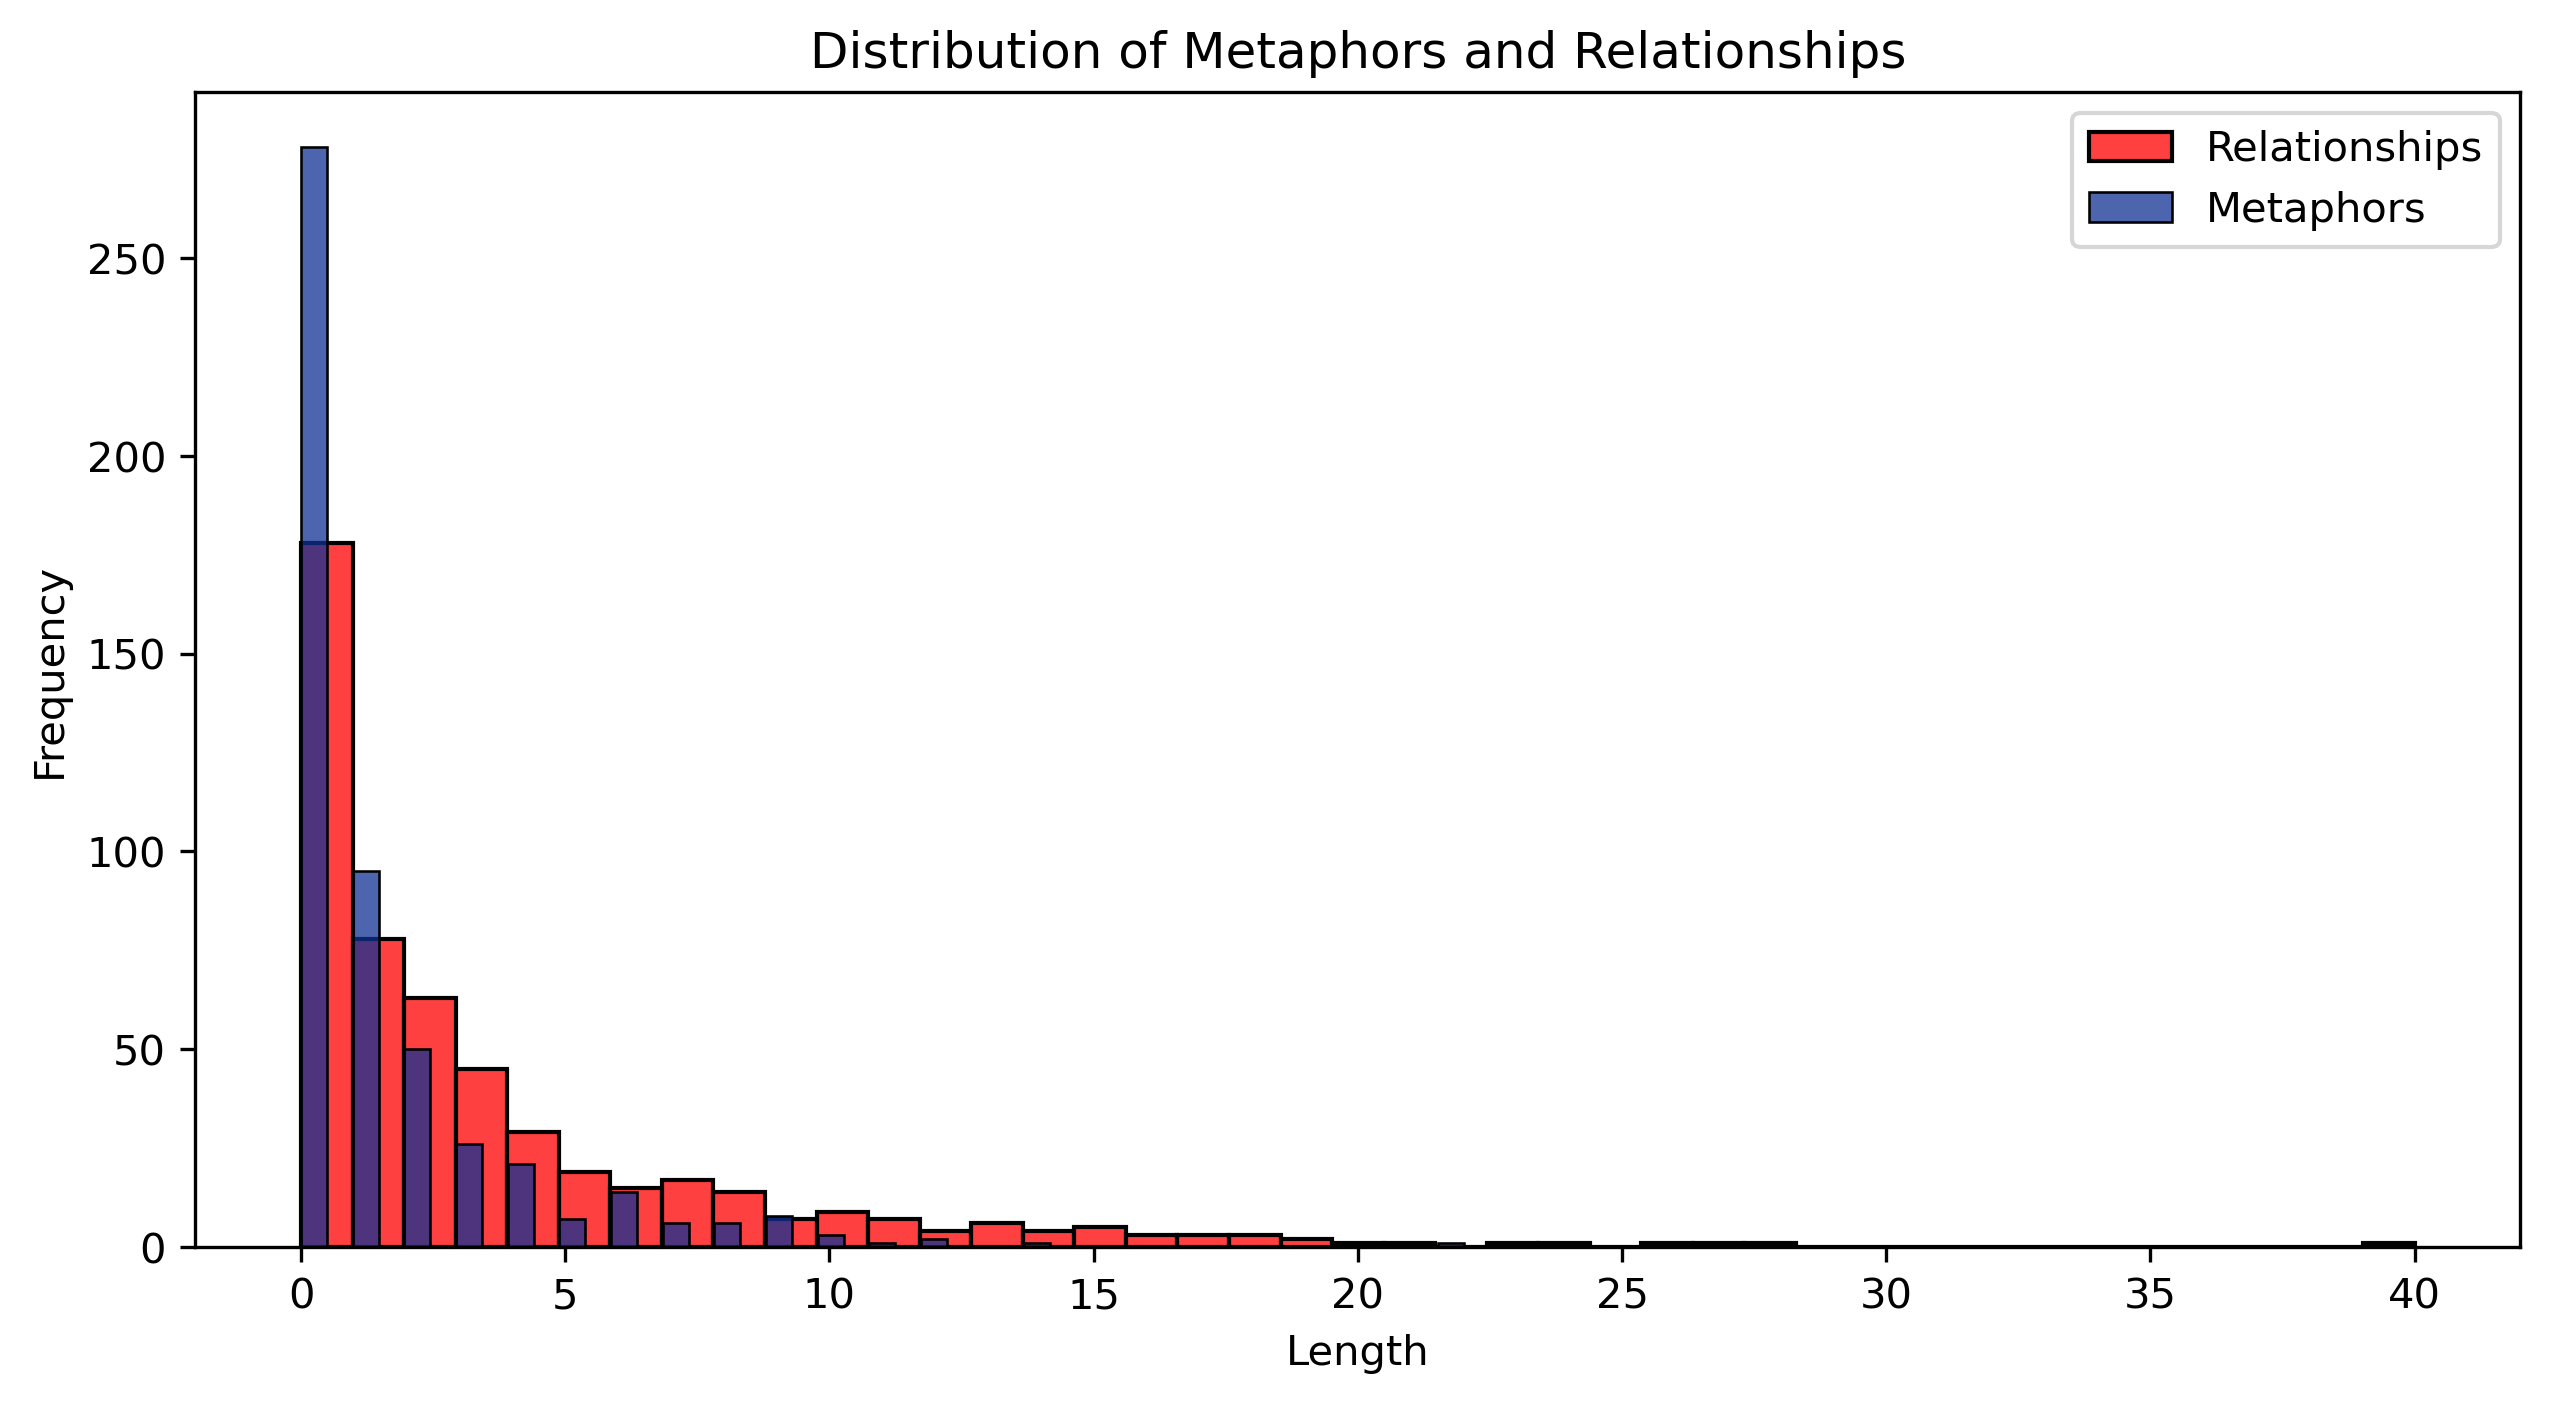

In [21]:
# Plot the length distribution from both columns
plt.figure(figsize=(10, 5), dpi=300)
sns.histplot(data=df, x='pos_relationships_len', color='red', label='Relationships')
sns.histplot(data=df, x='pos_metaphors_len', color=color, label='Metaphors')
plt.title('Distribution of Metaphors and Relationships')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

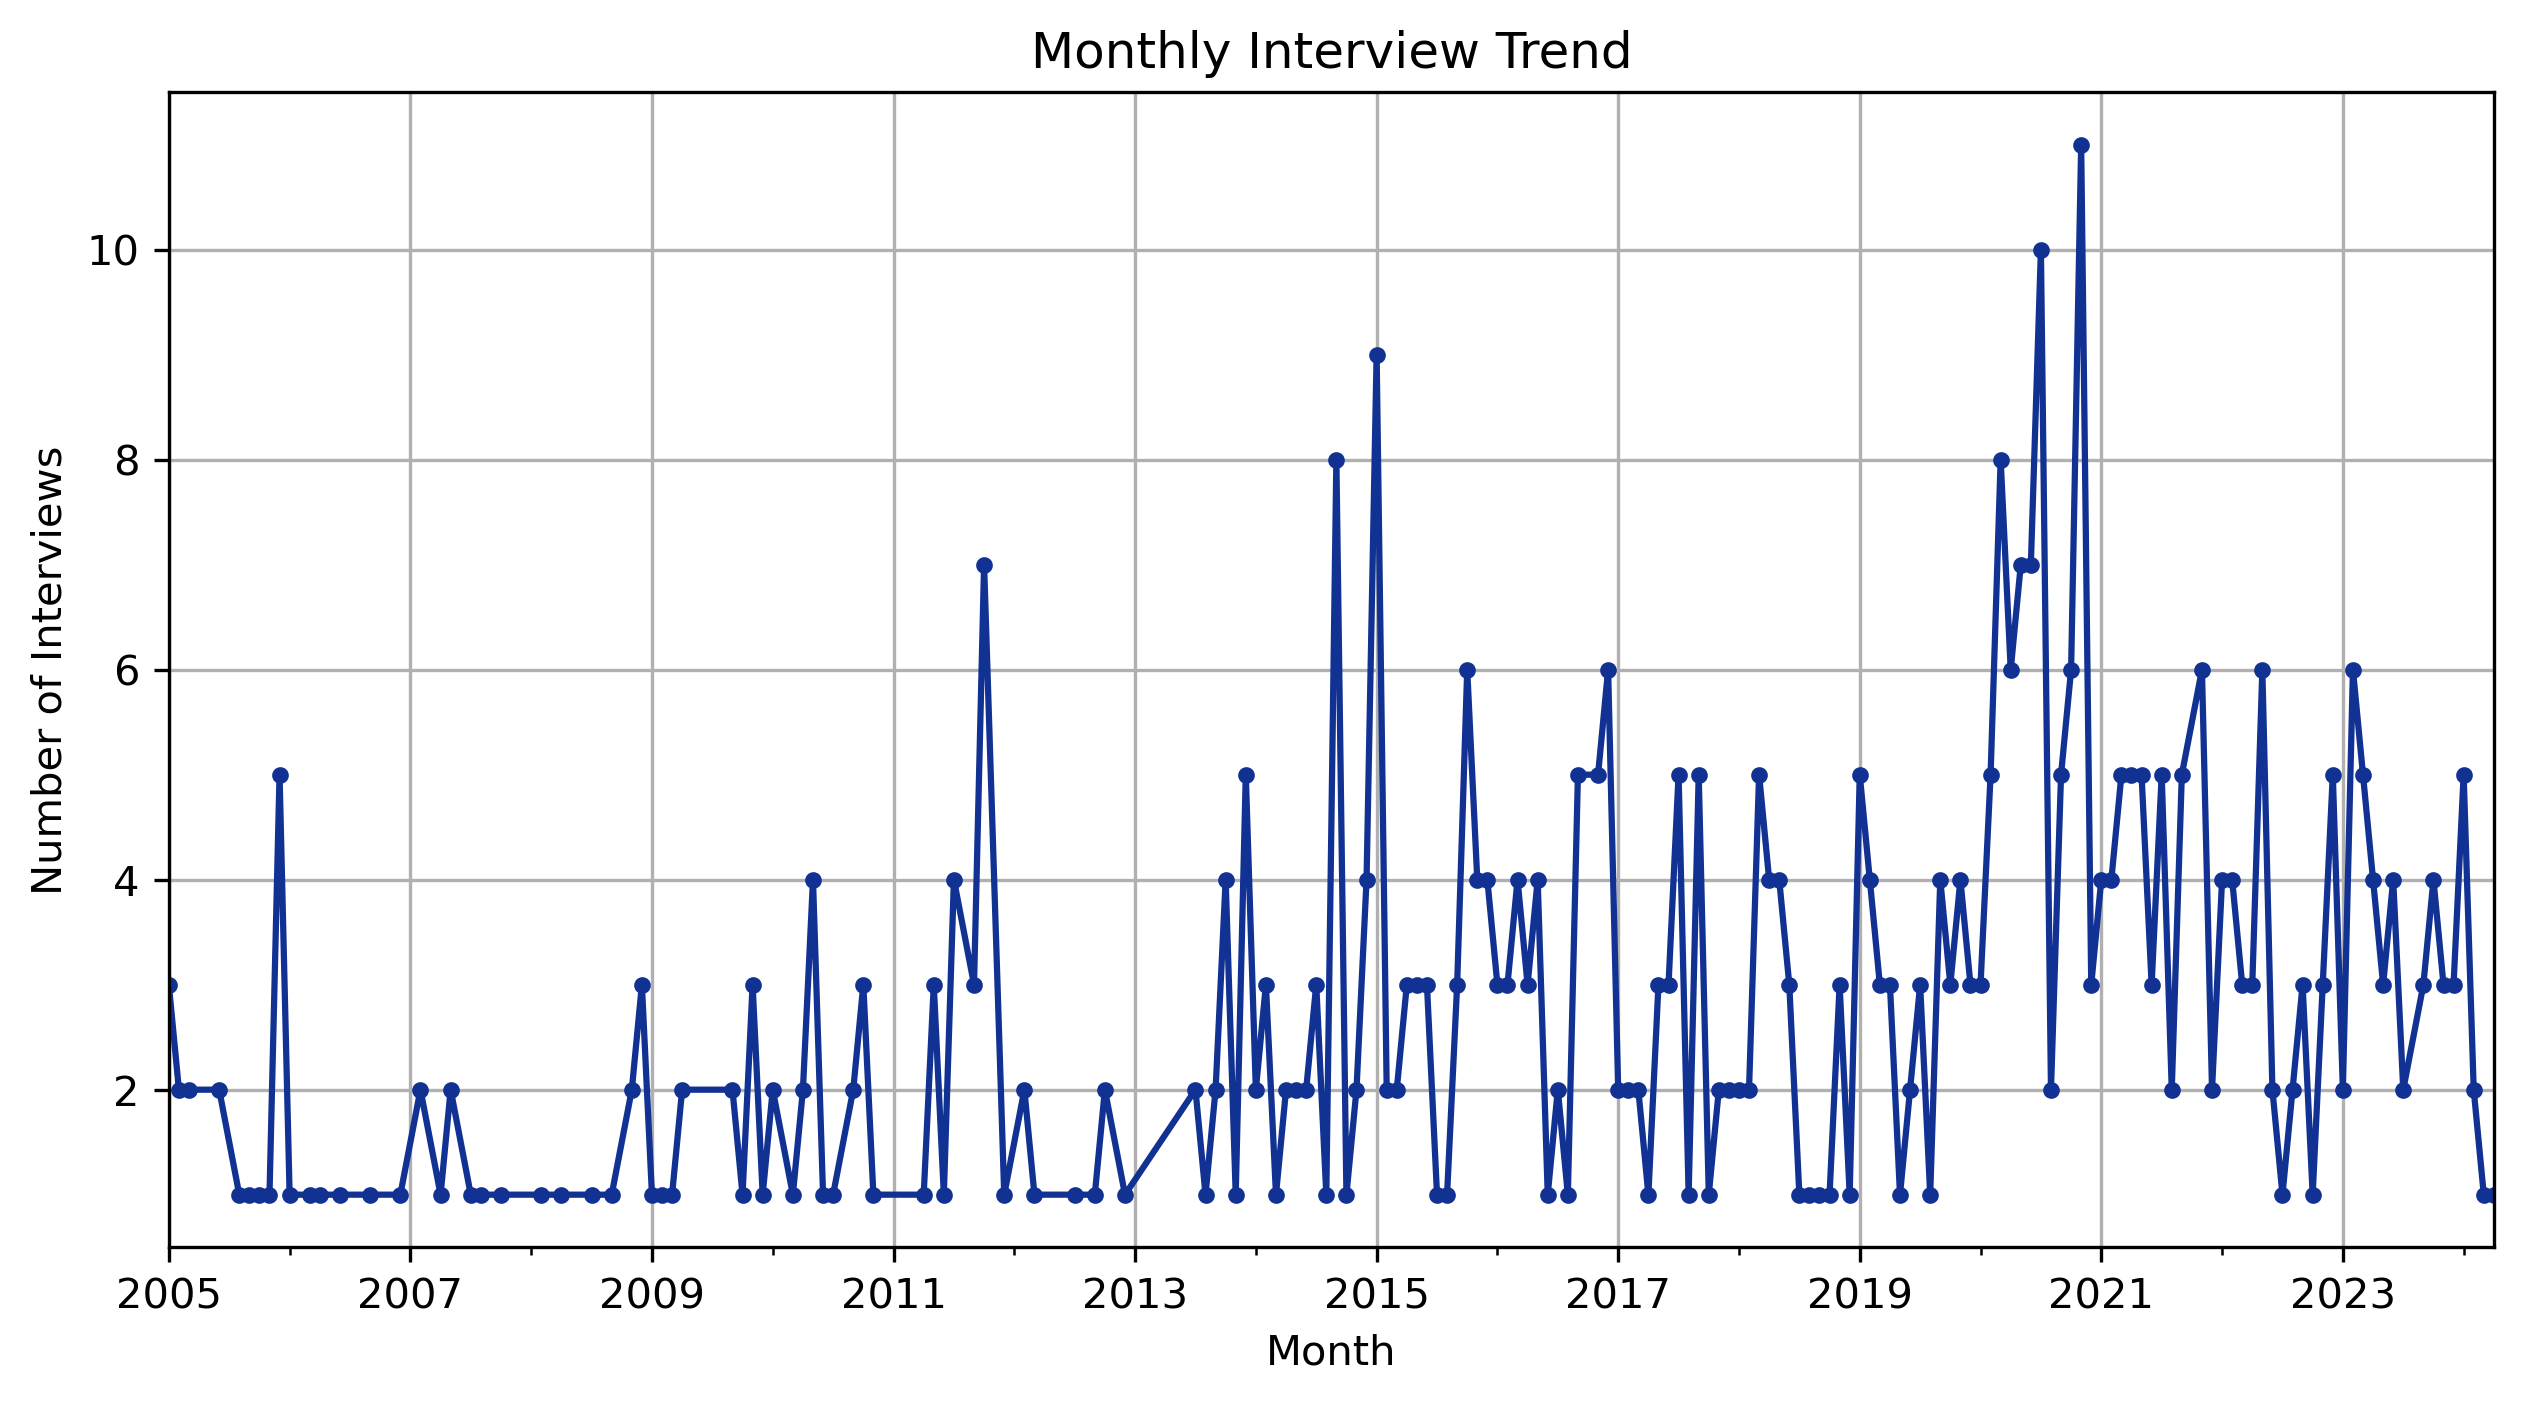

In [22]:
def trend_analysis(df):
    # Group by Year-Month and count entries
    trend_data = df.groupby(df['Date'].dt.to_period('M')).size()
    return trend_data

# Apply the function
monthly_trends = trend_analysis(df)

# Plotting the trend
plt.figure(figsize=(10, 5), dpi=300)
monthly_trends.plot(kind='line', marker='.', title='Monthly Interview Trend', color=color)
plt.xlabel('Month')
plt.ylabel('Number of Interviews')
plt.grid(True)
plt.show()

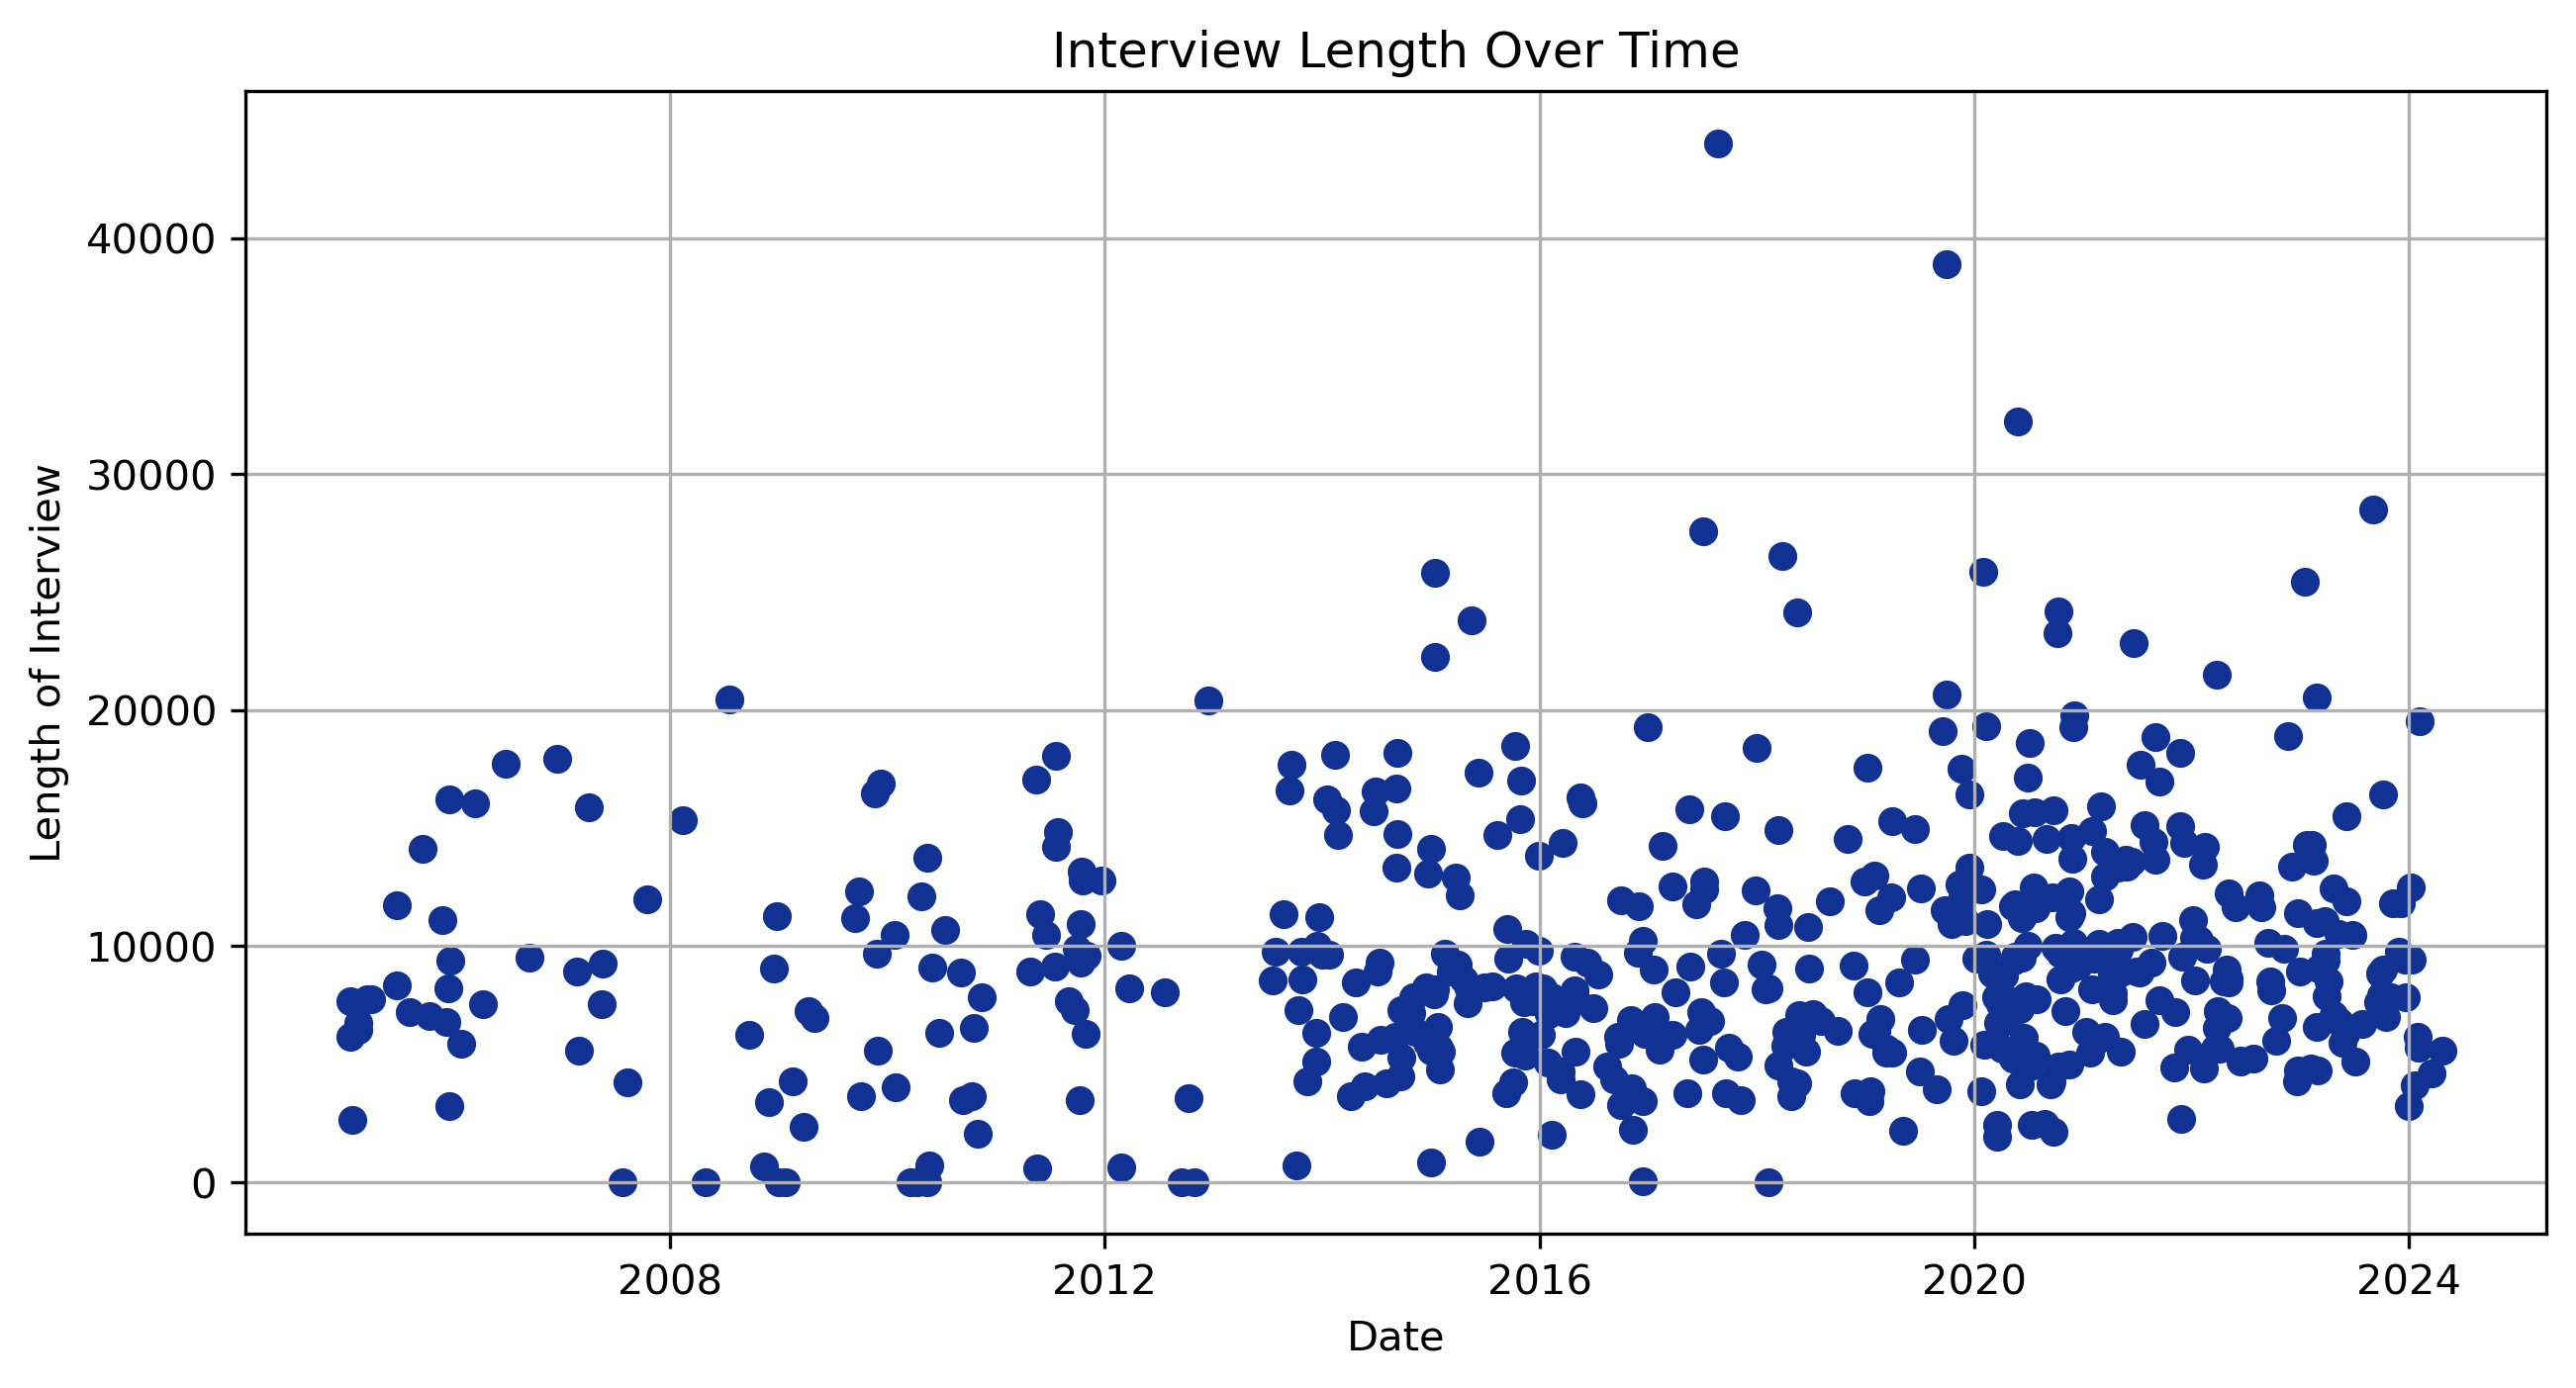

In [23]:
# Scatter plot of the interviews and their length
plt.figure(figsize=(10, 5), dpi=300)
plt.scatter(df['Date'], df['text_length'], color=color)
plt.title('Interview Length Over Time')
plt.xlabel('Date')
plt.ylabel('Length of Interview')
plt.grid(True)
plt.show()

C:\Users\School\AppData\Local\Temp\ipykernel_23808\2782053143.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')
C:\Users\School\AppData\Local\Temp\ipykernel_23808\2782053143.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))


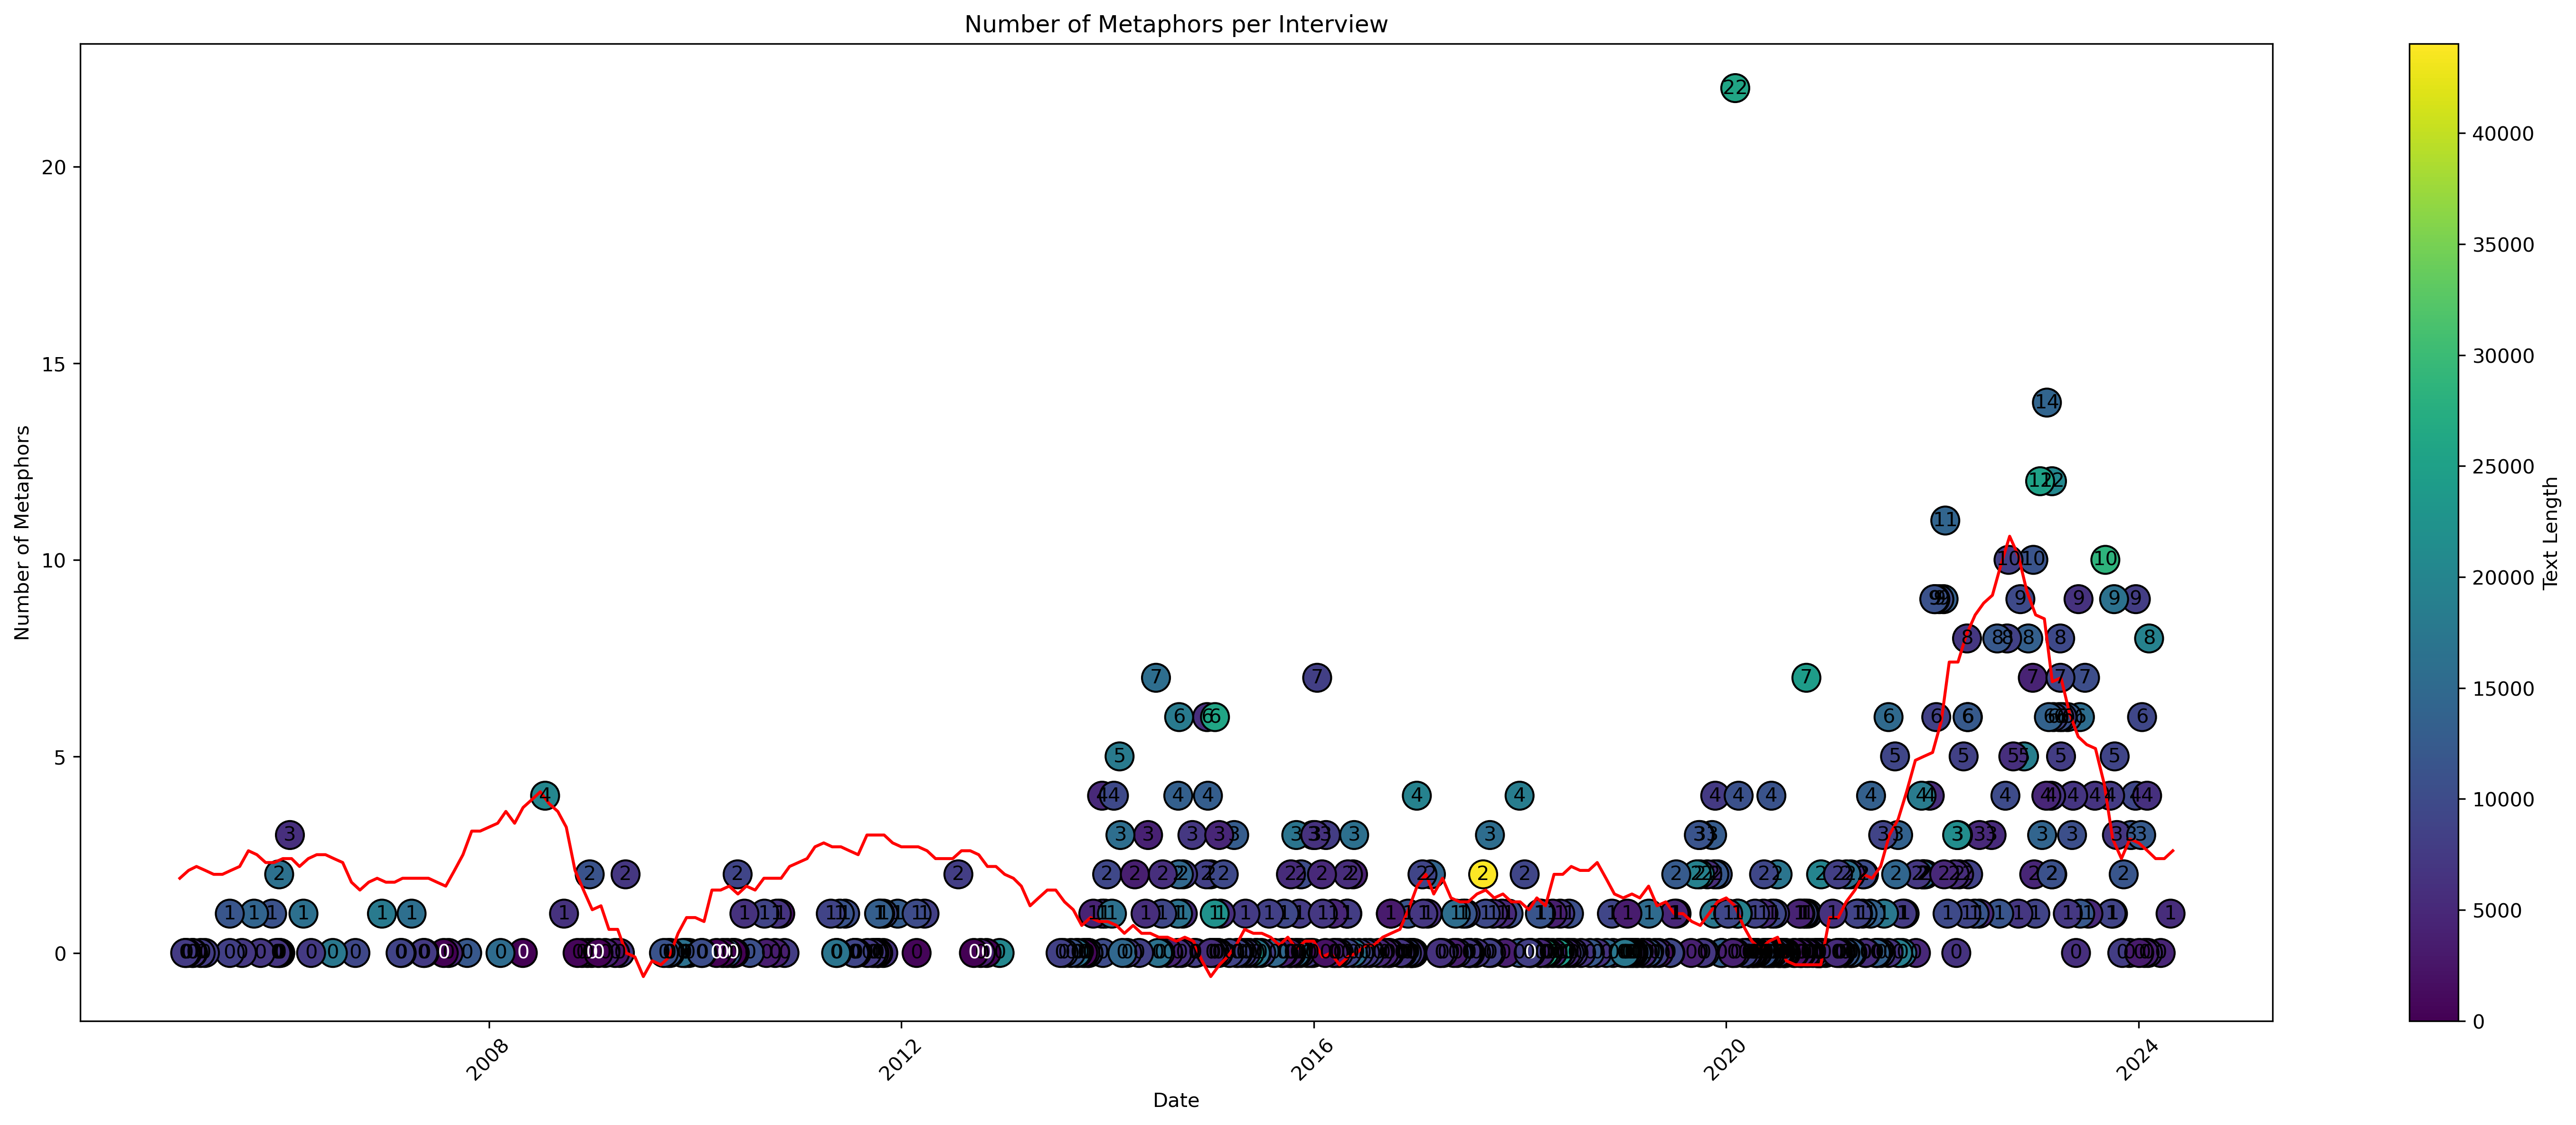

In [24]:
# Defining colors based on text length
norm = mcolors.Normalize(vmin=df['text_length'].min(), vmax=df['text_length'].max())
cmap = plt.cm.get_cmap('viridis')

# Create scatter plot
plt.figure(figsize=(20, 8), dpi=300)
sc = plt.scatter(df['Date'], df['pos_metaphors_len'], c=df['text_length'], cmap=cmap, norm=norm, s=200, edgecolors='k')

# Add text length colorbar
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Text Length')

# Add metaphor count labels inside the points
for i, row in df.iterrows():
    plt.text(row['Date'], row['pos_metaphors_len'], str(row['pos_metaphors_len']), ha='center', va='center', color='white' if row['text_length'] < 0.5 else 'black')

# Plot line for OBS_VALUE from df2
plt.plot(df2['TIME_PERIOD'], df2['OBS_VALUE'], color='red', label='OBS_VALUE')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Number of Metaphors')
plt.title('Number of Metaphors per Interview')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [25]:
"""# Save the dataframe
df = df.drop(columns=['pos_relationships', 'pos_relationships_len'])
df.to_csv("Final_Working_Data.csv", index=False)"""